# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [2]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from datetime import datetime,timezone
import dateutil.parser
import time
from datetime import timedelta
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS

# Data retrival from influx

In [ ]:
!pip3 install influxdb_client
!pip3 install statsmodels
!pip3 install sklearn

In [3]:
token = 'gYkhnh7Ft18AtFX8m7BEn3RQGb4vb9tcE_AbWkXFfXgpqU69ad3DQsKPvHW959iqN-mLFZW2wi6Pc7-XmohEAA=='
bucket = 'temperature'
org = 'iot_group'
client = InfluxDBClient(url="http://localhost:8086", token=token, org=org)
query_api = client.query_api()
write_api = client.write_api(write_options=SYNCHRONOUS)

In [4]:
query = 'from(bucket: "temperature")' \
  '|> range(start:2022-08-10T15:00:00Z, stop:2022-09-20T15:00:00Z)'

In [5]:
result = client.query_api().query(org=org, query=query)

-Exploiting the query results in order to obtain a dataframe

## Implementation Temperature Predictor

### ARIMA

In [3]:
dataset_path = "../datasets/temperature_dataset.csv"
df = pd.read_csv(dataset_path)
df.head()

,_time,_value,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,W_VEC_INT,LEAFW,ET0
0,2021-01-01 00:00:00,4.3,0.4,89.4,0.0,1.6,315.7,1.6,1.0,0.0
1,2021-01-01 01:00:00,4.1,0.4,88.6,0.0,0.8,340.7,0.7,1.0,0.0
2,2021-01-01 02:00:00,4.0,0.0,89.1,0.0,0.6,226.3,0.5,1.0,0.0
3,2021-01-01 03:00:00,3.8,0.2,91.7,0.0,0.7,17.9,0.4,1.0,0.0
4,2021-01-01 04:00:00,3.5,0.0,90.3,0.0,0.8,185.7,0.3,1.0,0.0


In [4]:
#time normalization
for t in df['_time'].values:
    d=dateutil.parser.parse(t)
    aux=d.strftime('%Y-%m-%d')
    df['_time'].replace({t:aux },inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


           _time  _value  PREC  RHAVG    RAD  W_SCAL_INT  W_VEC_DIR  W_VEC_INT  LEAFW  ET0
0     2021-01-01     4.3   0.4   89.4    0.0         1.6      315.7        1.6    1.0  0.0
1     2021-01-01     4.1   0.4   88.6    0.0         0.8      340.7        0.7    1.0  0.0
2     2021-01-01     4.0   0.0   89.1    0.0         0.6      226.3        0.5    1.0  0.0
3     2021-01-01     3.8   0.2   91.7    0.0         0.7       17.9        0.4    1.0  0.0
4     2021-01-01     3.5   0.0   90.3    0.0         0.8      185.7        0.3    1.0  0.0
5     2021-01-01     3.3   0.0   90.9    0.0         1.2      322.9        1.1    1.0  0.0
6     2021-01-01     2.7   0.2   92.7    0.0         1.3      323.9        1.1    1.0  0.0
7     2021-01-01     2.7   0.0   94.0    0.0         0.4      186.2        0.1    1.0  0.0
8     2021-01-01     2.9   0.0   94.3    5.5         0.6       68.6        0.3    1.0  0.0
9     2021-01-01     3.4   0.6   93.1   17.4         1.3       59.6        0.9    1.0  0.0

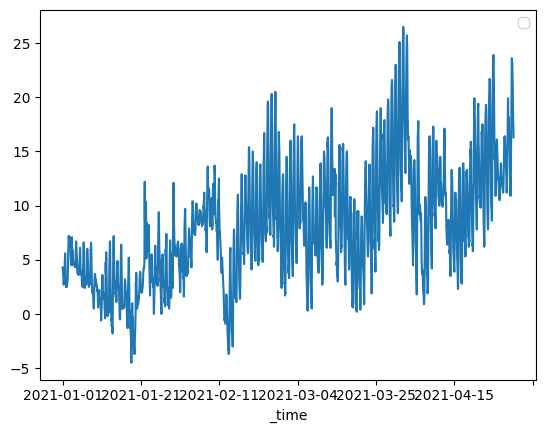

In [7]:
#evolution over time of our data
plot_cols = ['_value']
plot_features = df[plot_cols]
plot_features.index = df['_time']
print(df.to_string())
_ = plot_features.plot(subplots=True)



In [ ]:
df.describe()

In [112]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.60)
train = df['_value'] [:splitPoint]
test = df ['_value'] [splitPoint:]

## CALCOLO D


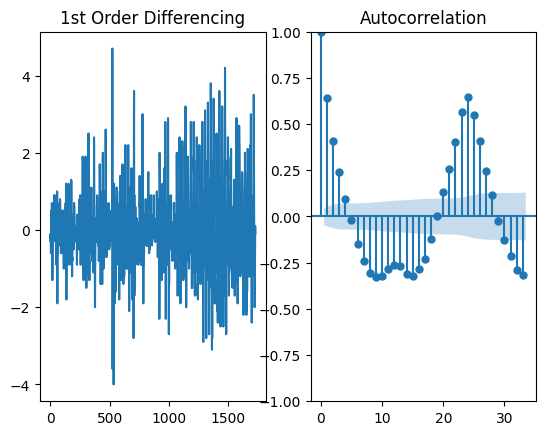

In [130]:
from statsmodels.graphics. tsaplots import plot_acf
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(train.diff())

ax2 = f.add_subplot(122)
plot_acf(train.diff().dropna(),ax=ax2)
plt.show()

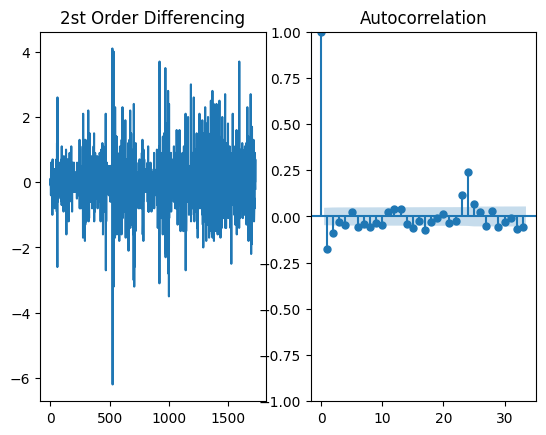

In [131]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2st Order Differencing')
ax1.plot(train.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(train.diff().diff().dropna(),ax=ax2)
plt.show()

In [129]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train.dropna())
print("p-value:" , result[1])
result = adfuller(train.diff().dropna())
print("p-value:" , result[1])
result = adfuller(train.diff().diff().dropna())
print("p-value:" , result[1])


p-value: 0.15098194033494433
p-value: 2.4754768762266734e-12
p-value: 0.0
p-value: 0.0


## CALCOLO Q

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


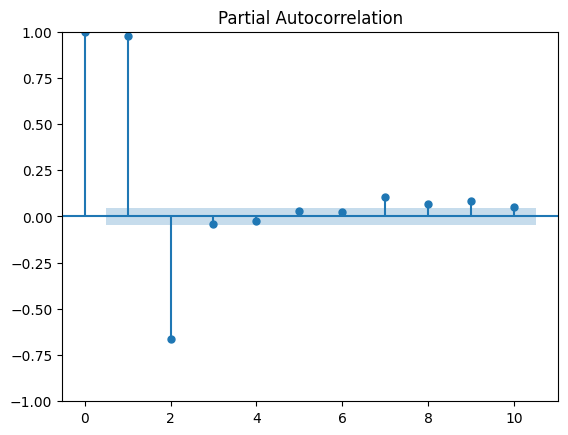

In [125]:
fig = tsaplots.plot_pacf(train.dropna(), lags=10)
plt.show()

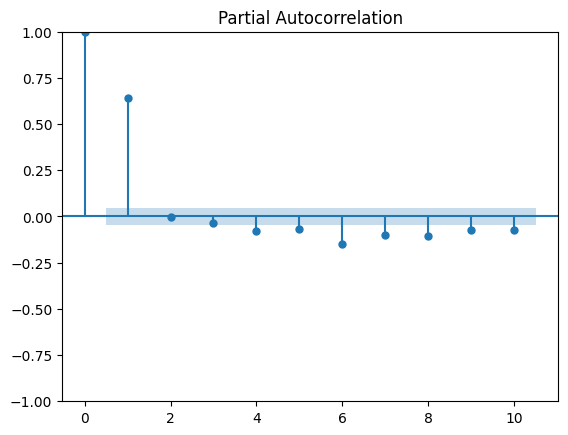

In [126]:
fig = tsaplots.plot_pacf(train.diff().dropna(), lags=10)
plt.show()

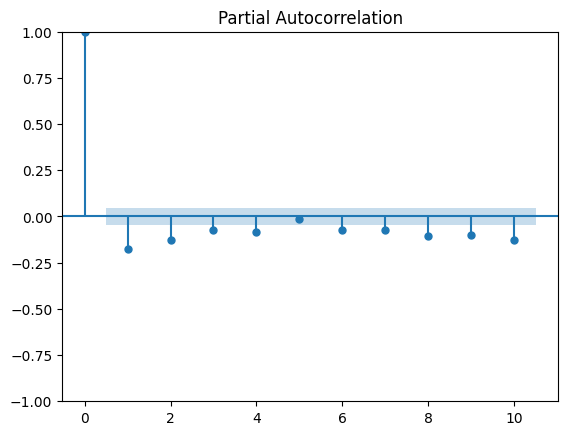

In [127]:
fig = tsaplots.plot_pacf(train.diff().diff().dropna(), lags=10)
plt.show()

In [ ]:
#Step 6; Apply ARIMA model
from statsmodels.tsa.arima.model import ARIMA
history = [x for x in train]
predictions = list()
print(test)
for t in test.index:
  #order=(p,d,q)
  model = ARIMA(history, order=(2,2,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs = test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

In [152]:

arima_model = ARIMA(train, order=(2,2,1))
model = arima_model.fit()
y_pred = pd.Series(model.forecast(20)[0], index=train[80:].index)
y_true = train[80:]
print (np. array(y_pred).astype(np.uint8))
print(np.arrav(y_true))


[0 0 0 ... 0 0 0]


AttributeError: module 'numpy' has no attribute 'arrav'

Test RMSE: 0.845


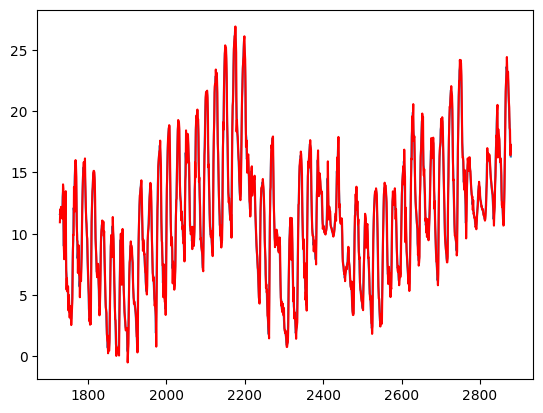

In [133]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show()

## Implementation Humidity Predictor

In [76]:
import csv
with open('../datasets/humidity_dataset.csv', 'r') as inp, open('../datasets/humidity_dataset_clean.csv', 'wb') as out:
    writer = csv.writer(out)
    reader = csv.reader(inp) 
    for row in reader:
        if row[0] == "Lambrate":
            writer.writerow(row.encode('utf-8'))

TypeError: a bytes-like object is required, not 'str'

In [ ]:

dataset_path = "/content/drive/MyDrive/Datasets/Forecasting/hum.csv"
df = pd.read_csv(dataset_path)
df.head()

In [ ]:
df = df.rename(columns={"409151bfa0cc" : 'time', "409151bfa0cc.1" : 'y'})
df.head()

In [ ]:
#evolution over time of our data
plot_cols = ['y']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

In [ ]:
df.describe().transpose()

In [ ]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.60)
train = df['y'] [:splitPoint]
test = df ['y'] [splitPoint:]

In [ ]:
 # Check whether the time-series is stationary through the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
train_new = train.diff().dropna()
result = adfuller(train_new)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
fig = tsaplots.plot_acf(train_new, lags=10)
plt.show()

In [ ]:
fig = tsaplots.plot_pacf(train_new, lags=10)
plt.show()

In [ ]:
history = [x for x in train]
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(1,1,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

In [ ]:
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd.DataFrame(predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show()

## Implement Gas Predictor

In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/Forecasting/gas.csv"
df = pd.read_csv(dataset_path)

In [ ]:
df.head()

In [ ]:
df['y'].size

In [ ]:
df['y'][0:4288] = 4095

In [ ]:
#evolution over time of our data
plot_cols = ['y']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

In [ ]:
df['y'][3000:4000] = [4095 for i in range(0,1000)]

In [ ]:
df.describe().transpose()

In [ ]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.50)
train = df['y'] [:splitPoint]
test = df ['y'] [splitPoint:]

Check for stationarity 

In [ ]:
 # Check whether the time-series is stationary through the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
train_new = train.diff().dropna()
result = adfuller(train_new)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train, lags=10)
plt.show()

In [ ]:
fig = tsaplots.plot_pacf(train, lags=10)
plt.show()

In [ ]:
# Apply ARIMA model
from statsmodels.tsa.arima_model import ARIMA
history = list(np.array([x for x in train_new]).astype('float64'))
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(1,1,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

In [ ]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show()

In [ ]:
plt.plot(test)


In [ ]:
import pickle
pickle.dump(model_fit, open('gas-model', 'wb'))